# Class imbalance

Class imbalance across the space can be a serious issue when trying to build a geographically weighted classification model. You can get to such extreme situations, that all of the observations within the set bandwidth share a single value. In that case, fitting a model that would predicting anything else than that value is not possible.

Even in less extreme cases, the class imbalance can induce bias to the local model.

In [ ]:
import geopandas as gpd
import numpy as np
from geodatasets import data
from sklearn import metrics

from gwlearn.ensemble import GWRandomForestClassifier


## Initial situation

Use the Guerry dataset and create a binary variable to predict. Use a subset of other columns as explanatory variables.

In [2]:
gdf = gpd.read_file(data.geoda.guerry.path)
y = gdf["Suicids"] > gdf["Suicids"].median()
X = gdf[['Crm_prp', 'Litercy', 'Donatns', 'Lottery']]

Fit the model using the default settings.

In [3]:
model = GWRandomForestClassifier(
    geometry=gdf.representative_point(),
    bandwidth=25,
    fixed=False,
)
model.fit(
    X,
    y,
)

,bandwidth,25
,fixed,False
,kernel,'bisquare'
,include_focal,False
,geometry,0 POINT (...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None


By default, the class imbalance affects which models are fitted and which are not. The default for the `min_proportion` parameter is 0.2, meaning the minority class needs to occur in at least 20% of observations within a local bandwidth. Otherwise, the model is not fitted. You can check how many local models are fitted under these conditions.

In [4]:
model.prediction_rate_

np.float64(0.9058823529411765)

You can see that visually if you map the outcome of the focal prediction.

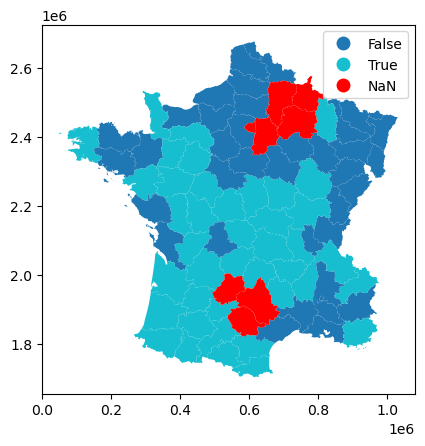

In [5]:
gdf.plot(model.pred_, missing_kwds=dict(color='red'), legend=True);

The local performance for such a model then looks like this.

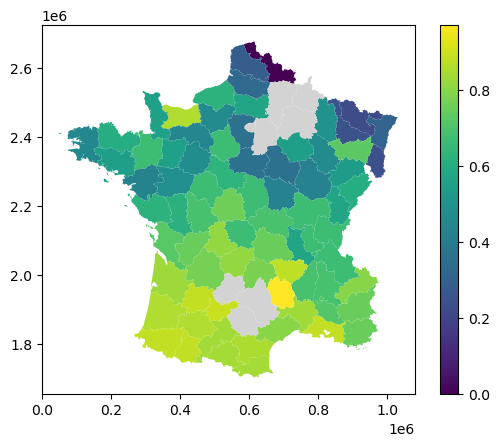

In [6]:
local_f1 = model.local_metric(metrics.f1_score)

gdf.plot(local_f1, missing_kwds=dict(color='lightgray'), legend=True);

## Adapting the allowed proportion

The first thing you can do is to adapt the allowed minimum proportion. If you want to have less imbalanced models, you can increase it at the cost of more local models being skipped.

In [7]:
stricter_model = GWRandomForestClassifier(
    geometry=gdf.representative_point(),
    bandwidth=25,
    fixed=False,
    min_proportion=0.3
)
stricter_model.fit(
    X,
    y,
)

,bandwidth,25
,fixed,False
,kernel,'bisquare'
,include_focal,False
,geometry,0 POINT (...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None


See how does that affect prediction rate.

In [8]:
stricter_model.prediction_rate_

np.float64(0.788235294117647)

About 12% less models can be fitted.

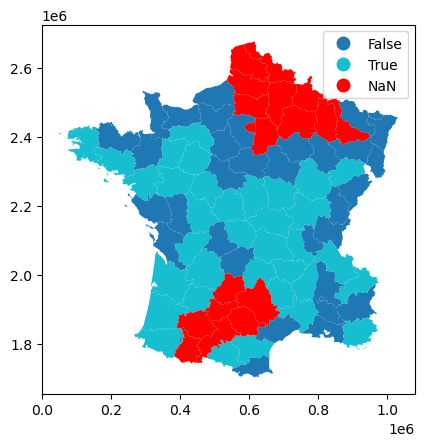

In [9]:
gdf.plot(stricter_model.pred_, missing_kwds=dict(color='red'), legend=True);

## Undersampling

Another strategy to battle with class imbalance, is to undersample data in each local model. By default, this is False, but can be set to True or a float. True ensured that both classes are equally represented, while float defines the minimum proportion of the minority class after resampling.

In [10]:
equal_model = GWRandomForestClassifier(
    geometry=gdf.representative_point(),
    bandwidth=25,
    fixed=False,
    min_proportion=0.3,
    undersample=True,
)
equal_model.fit(
    X,
    y,
)

,bandwidth,25
,fixed,False
,kernel,'bisquare'
,include_focal,False
,geometry,0 POINT (...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None


This does not affect the prediction rate.

In [11]:
equal_model.prediction_rate_

np.float64(0.788235294117647)

But does affect local, and hence global, performance of the model.

In [13]:
equal_f1 = equal_model.local_metric(metrics.f1_score)
stricter_f1 = stricter_model.local_metric(metrics.f1_score)

diff = equal_f1 - stricter_f1

See the difference in local F1 scores compared to a model without undersampling.

<Axes: >

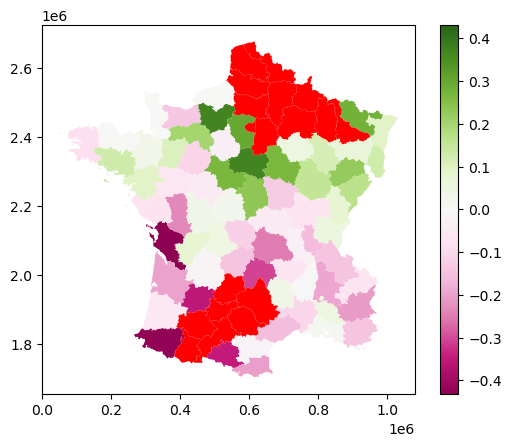

In [28]:
gdf.plot(diff, legend=True, missing_kwds=dict(color='red'), cmap='PiYG', vmax=np.nanmax(np.abs(diff)))

Keep in mind that for models like this one, where we use only 25 observations in each local model, undersampling can have a severe efect on the model robustness in a negative way, as it may reduce the number of observations that are actually used by quite a lot. Use with caution and ideally in situations where you rely on a larger number of neighbors.